# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the corpus
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Calculate vocabulary size
total_words = len(tokenizer.word_index) + 1
print(f"Total unique words: {total_words}")

Total unique words: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
# Create input sequences
input_sequences = []

for line in corpus:
    # Convert the line of text into a sequence of integers
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Create n-grams
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Veamos algunas secuencias originales
print("Primeras 3 secuencias antes del padding:")
for seq in input_sequences[:3]:
    print(seq)

Primeras 3 secuencias antes del padding:
[3, 2]
[3, 2, 313]
[3, 2, 313, 1375]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
# Find the length of the longest sequence
max_sequence_len = max([len(x) for x in input_sequences])
print(f"\nLongitud máxima de secuencia: {max_sequence_len}")

# Pad sequences to make them all the same length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
print("\nPrimeras 3 secuencias después del padding:")
for seq in input_sequences[:3]:
    print(seq)

# Para ver las palabras reales, podemos decodificar una secuencia
print("\nEjemplo decodificado:")
# Creamos un diccionario inverso para convertir números a palabras
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(sequence):
    return ' '.join(reverse_word_map.get(i, '?') for i in sequence if i != 0)

print("Secuencia numérica:", input_sequences[0])
print("Texto decodificado:", sequence_to_text(input_sequences[0]))


Longitud máxima de secuencia: 11

Primeras 3 secuencias después del padding:
[0 0 0 0 0 0 0 0 0 3 2]
[  0   0   0   0   0   0   0   0   3   2 313]
[   0    0    0    0    0    0    0    3    2  313 1375]

Ejemplo decodificado:
Secuencia numérica: [0 0 0 0 0 0 0 0 0 3 2]
Texto decodificado: to the


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Split sequences into input and output
predictors = input_sequences[:, :-1]
labels = input_sequences[:, -1]

print("\nForma de los predictores:", predictors.shape)
print("Forma de las etiquetas:", labels.shape)

print("\nEjemplo de predictor y etiqueta:")
print("Predictor:", sequence_to_text(predictors[0]))
print("Etiqueta:", sequence_to_text([labels[0]]))


Forma de los predictores: (15484, 10)
Forma de las etiquetas: (15484,)

Ejemplo de predictor y etiqueta:
Predictor: to
Etiqueta: the


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
# One-hot encode the labels
labels = ku.to_categorical(labels, num_classes=total_words)

print("Forma de las etiquetas después de one-hot encoding:", labels.shape)
print("\nEjemplo de una etiqueta one-hot:")
print("Índice original:", np.argmax(labels[0]))
print("Vector one-hot:", labels[0][:10], "...") # Mostramos solo los primeros 10 valores

Forma de las etiquetas después de one-hot encoding: (15484, 3375)

Ejemplo de una etiqueta one-hot:
Índice original: 2
Vector one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] ...


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
model = Sequential([
    # Capa de Embedding: convierte índices de palabras en vectores densos
    Embedding(input_dim=total_words, output_dim=100),
    
    # Primera capa LSTM bidireccional
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    
    # Segunda capa LSTM
    LSTM(100),
    
    # Capa densa intermedia con regularización
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    
    # Capa de salida
    Dense(total_words, activation='softmax')
])


2025-01-08 11:57:09.064563: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-08 11:57:09.064580: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-08 11:57:09.064585: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-08 11:57:09.064766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 11:57:09.064776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("Configuración del modelo:")
print("- Loss function: Categorical Crossentropy")
print("- Optimizer: Adam (learning rate = 0.001)")
print("- Metrics: Accuracy")

# Construir el modelo con las dimensiones de los datos
model.build(input_shape=(None, max_sequence_len-1))

Configuración del modelo:
- Loss function: Categorical Crossentropy
- Optimizer: Adam (learning rate = 0.001)
- Metrics: Accuracy


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
# Imprimir resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [12]:
# Entrenar el modelo
history = model.fit(
    predictors,
    labels,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

print("\nResumen del entrenamiento:")
print(f"Épocas completadas: {len(history.history['loss'])}")
print(f"Accuracy final: {history.history['accuracy'][-1]:.4f}")
print(f"Loss final: {history.history['loss'][-1]:.4f}")

Epoch 1/50


2025-01-08 11:57:09.861447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.0213 - loss: 8.0441 - val_accuracy: 0.0123 - val_loss: 6.9031
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.0262 - loss: 6.5399 - val_accuracy: 0.0219 - val_loss: 6.9661
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.0209 - loss: 6.4717 - val_accuracy: 0.0226 - val_loss: 7.0625
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.0229 - loss: 6.3531 - val_accuracy: 0.0252 - val_loss: 7.0235
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.0324 - loss: 6.2508 - val_accuracy: 0.0252 - val_loss: 7.1756
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.0345 - loss: 6.1804 - val_accuracy: 0.0245 - val_loss: 7.1482
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.0364 - loss: 6.0988 - val_accuracy: 0.0239 - val_loss: 7.1479
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.0374 - loss: 6.0433 - val

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

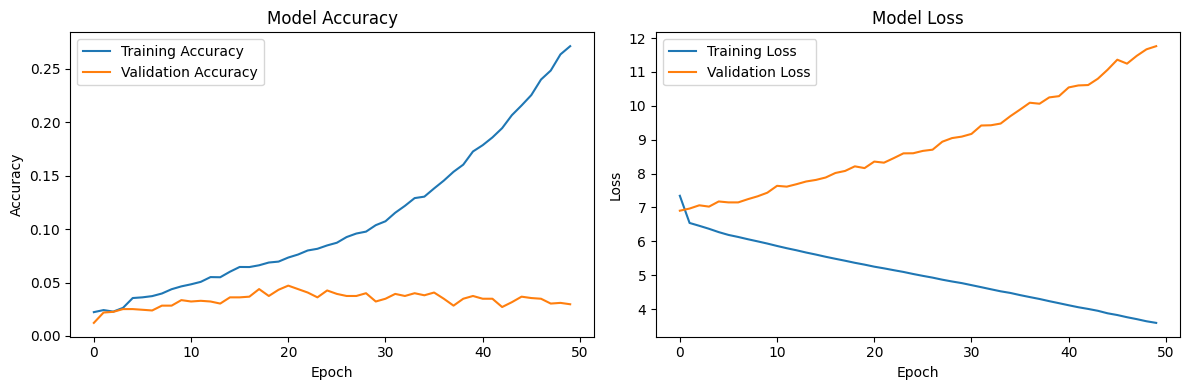

In [17]:
import matplotlib.pyplot as plt

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 4))

# Subplot para accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot para loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [18]:
# Definir función para generar texto
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Tokenizar el texto semilla
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Padding
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predecir
        predicted = model.predict(token_list, verbose=0)
        # Obtener el índice de la palabra con mayor probabilidad
        predicted = np.argmax(predicted, axis=-1)
        # Convertir el índice a palabra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Añadir la palabra al texto semilla
        seed_text += " " + output_word
    return seed_text

# Probar la generación
seed_text = "shall i compare thee to"
next_words = 20

print("Texto generado:")
print(generate_text(seed_text, next_words, model, max_sequence_len))

Texto generado:
shall i compare thee to my love of men ' write to me prove thee my report state truth ' lie to thee shines none


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [19]:
# Probar diferentes semillas de texto
seed_texts = [
    "shall i compare thee to",
    "my love is like a",
    "when in disgrace with fortune"
]

print("Generando diferentes textos:\n")
for seed in seed_texts:
    print(f"Semilla: '{seed}'")
    generated = generate_text(seed, next_words=20, model=model, max_sequence_len=max_sequence_len)
    print(f"Resultado: {generated}\n")

Generando diferentes textos:

Semilla: 'shall i compare thee to'
Resultado: shall i compare thee to my love of men ' write to me prove thee my report state truth ' lie to thee shines none

Semilla: 'my love is like a'
Resultado: my love is like a stage starved yet to me be none dead hate dwell say lie alone to me more are old more report

Semilla: 'when in disgrace with fortune'
Resultado: when in disgrace with fortune and lend me eye do show me say shines art time say such tend respect lie to me prove me



Experiment with at least 3 different seed_text strings and see what happens!

In [20]:
def generate_shakespeare(seed_text, num_words=20):
    """
    Función interactiva para generar texto estilo Shakespeare
    """
    print(f"\nGenerando {num_words} palabras a partir de: '{seed_text}'")
    result = generate_text(seed_text, num_words, model, max_sequence_len)
    print("\nTexto generado:")
    print(result)
    return result

# Ejemplos de uso con diferentes longitudes
print("Experimento 1: Texto corto")
generate_shakespeare("love is", 10)

print("\nExperimento 2: Texto medio")
generate_shakespeare("the world is", 15)

print("\nExperimento 3: Texto largo")
generate_shakespeare("in the summer's day", 25)

Experimento 1: Texto corto

Generando 10 palabras a partir de: 'love is'

Texto generado:
love is my heart in thy sake phoenix and such green thee

Experimento 2: Texto medio

Generando 15 palabras a partir de: 'the world is'

Texto generado:
the world is found in a dream doth part ' none often of thee men lie ' are

Experimento 3: Texto largo

Generando 25 palabras a partir de: 'in the summer's day'

Texto generado:
in the summer's day is lost in my love of me uphold ride grow men ' none made me lie of men too report lie by thee green me


"in the summer's day is lost in my love of me uphold ride grow men ' none made me lie of men too report lie by thee green me"

Otros metodos:

=== Comparación de Diferentes Métodos de Generación de Texto ===

1. Método Original:
Resultado: shall i compare thee to my love of men ' write to me prove thee my report state truth ' lie to thee shines none

2. Método con Temperature Sampling:
- Temperature baja (más conservador):
Resultado (T=0.3): shall i compare thee to my mind's mad ' free ' none fled ' but to me last have lie to me do me prove

- Temperature alta (más creativo):
Resultado (T=1.2): shall i compare thee to a less eyes stay each canopy make this erred bankrupt is these such green more lie of her leaves shine

3. Método con Beam Search:
Resultado: shall i compare thee to my head doth cross ' say to me away you am free free free free free free free free free


=== Evaluación de Generaciones ===

Método Original:
- BLEU Score: 0.1410
- Longitud: 25 palabras
- Texto: shall i compare thee to my love of men ' write to me prove thee my report state truth ' lie to thee shines none

Temperature Baja (0.3):
- BLEU Score: 0.1

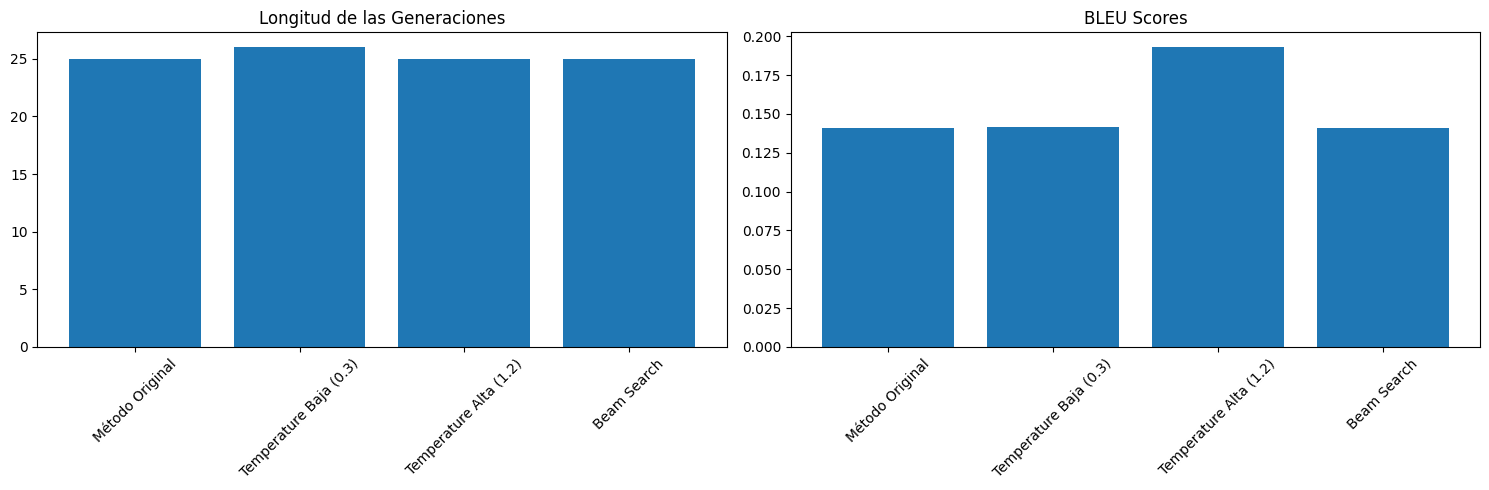

In [22]:
# === Experimentación con Diferentes Métodos ===
print("=== Comparación de Diferentes Métodos de Generación de Texto ===\n")

# 1. Método Original
print("1. Método Original:")
original_text = generate_text("shall i compare thee to", 20, model, max_sequence_len)
print(f"Resultado: {original_text}\n")

# 2. Método con Temperature Sampling
def generate_with_temperature(seed_text, next_words, temperature=0.7):
    result = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        predictions = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)
        
        predicted = np.random.choice(len(predictions), p=predictions)
        
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                result += " " + word
                break
    return result

print("2. Método con Temperature Sampling:")
print("- Temperature baja (más conservador):")
temp_low = generate_with_temperature("shall i compare thee to", 20, temperature=0.3)
print(f"Resultado (T=0.3): {temp_low}\n")

print("- Temperature alta (más creativo):")
temp_high = generate_with_temperature("shall i compare thee to", 20, temperature=1.2)
print(f"Resultado (T=1.2): {temp_high}\n")

# 3. Método con Beam Search
def generate_with_beam_search(seed_text, next_words, beam_width=3):
    candidates = [(seed_text, 0.0)]
    
    for _ in range(next_words):
        all_candidates = []
        for text, score in candidates:
            token_list = tokenizer.texts_to_sequences([text])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
            predictions = model.predict(token_list, verbose=0)[0]
            
            # Get top k predictions
            top_k = np.argsort(predictions)[-beam_width:]
            
            for token_id in top_k:
                for word, index in tokenizer.word_index.items():
                    if index == token_id:
                        candidate = text + " " + word
                        candidate_score = score + np.log(predictions[token_id])
                        all_candidates.append((candidate, candidate_score))
                        break
        
        # Select top beam_width candidates
        candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    
    return candidates[0][0]  # Return the best sequence

print("3. Método con Beam Search:")
beam_text = generate_with_beam_search("shall i compare thee to", 20)
print(f"Resultado: {beam_text}\n")

# Comparación de métricas
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

def evaluate_generations(reference, generations):
    print("\n=== Evaluación de Generaciones ===")
    reference_tokens = word_tokenize(reference.lower())
    
    for name, generated in generations:
        generated_tokens = word_tokenize(generated.lower())
        bleu_score = sentence_bleu([reference_tokens], generated_tokens)
        print(f"\n{name}:")
        print(f"- BLEU Score: {bleu_score:.4f}")
        print(f"- Longitud: {len(generated_tokens)} palabras")
        print(f"- Texto: {generated}")

# Soneto original para comparación
reference = "Shall I compare thee to a summer's day? Thou art more lovely and more temperate"

generations = [
    ("Método Original", original_text),
    ("Temperature Baja (0.3)", temp_low),
    ("Temperature Alta (1.2)", temp_high),
    ("Beam Search", beam_text)
]

evaluate_generations(reference, generations)

# Visualización de comparación
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Longitud de las Generaciones")
lengths = [len(word_tokenize(gen[1])) for gen in generations]
plt.bar([gen[0] for gen in generations], lengths)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.title("BLEU Scores")
bleu_scores = [sentence_bleu([word_tokenize(reference.lower())], 
                           word_tokenize(gen[1].lower())) 
               for gen in generations]
plt.bar([gen[0] for gen in generations], bleu_scores)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Otras Mejoras:

In [24]:
# === Bloque 1: Importaciones Adicionales ===
import numpy as np
from transformers import GPT2Tokenizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import math
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
import pandas as pd
import seaborn as sns
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('wordnet')

/opt/anaconda3/envs/tfgpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/joseortiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joseortiz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

=== Análisis del Texto Original vs Procesado ===

Comparación de métricas:
                     Original  Procesado
total_lines       2634.000000        1.0
avg_line_length      6.719058    17720.0
unique_words      4864.000000     3616.0
total_words      17698.000000    17720.0


<Figure size 1200x600 with 0 Axes>

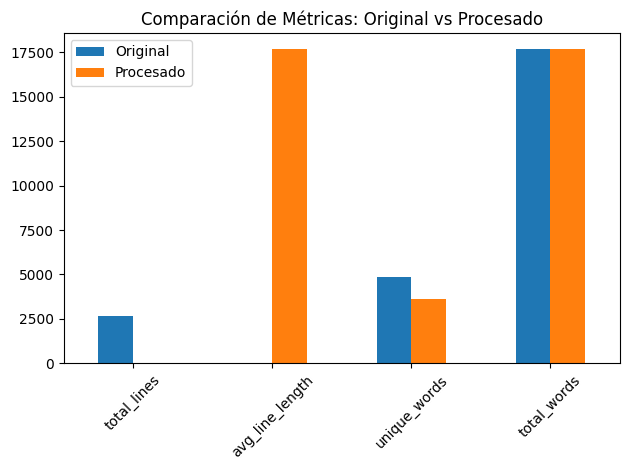


=== Análisis del Vocabulario ===

vocab_size:
3369

most_common:
[('and', 490), ('the', 446), ('to', 410), ('of', 372), ('my', 363), ('i', 341), ('in', 323), ('that', 321), ('thy', 266), ('thou', 234)]

rare_words:
[('legions', 1), ("warm'd", 1), ('sleeping', 1), ('virgin', 1), ("disarm'd.", 1), ('quenched', 1), ('cool', 1), ('thrall', 1), ('heats', 1), ('cools', 1)]

mean_freq:
4.900442477876106


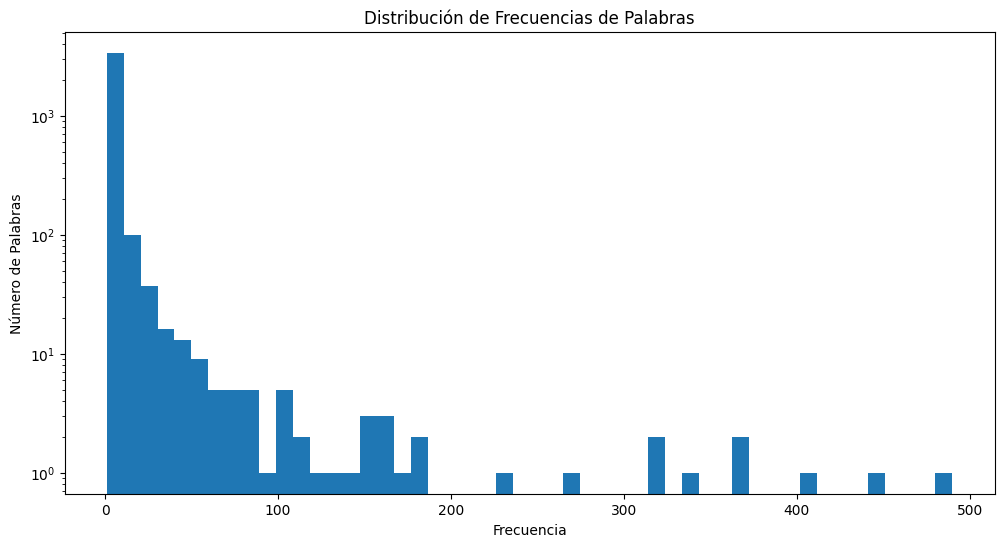

In [25]:
# === Bloque 2: Preprocesamiento Mejorado ===
import re
from collections import defaultdict
import string
from tqdm import tqdm

class TextPreprocessor:
    def __init__(self):
        self.contractions = {
            "'tis": "it is", "'twas": "it was", 
            "o'er": "over", "e'er": "ever",
            "'gainst": "against", "'midst": "amidst"
        }
        
    def clean_text(self, text):
        """Limpieza avanzada del texto"""
        # Normalización básica
        text = text.lower()
        
        # Manejo de contracciones shakespearianas
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        
        # Normalización de puntuación
        text = re.sub(r'[^\w\s\'\-\.]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def analyze_text_structure(self, text):
        """Análisis de la estructura del texto"""
        lines = text.split('\n')
        metrics = {
            'total_lines': len(lines),
            'avg_line_length': sum(len(line.split()) for line in lines) / len(lines),
            'unique_words': len(set(text.split())),
            'total_words': len(text.split())
        }
        return metrics

# Inicializar el preprocesador
preprocessor = TextPreprocessor()

# Procesar el texto original y mostrar estadísticas
print("=== Análisis del Texto Original vs Procesado ===")
original_metrics = preprocessor.analyze_text_structure(data)
processed_text = preprocessor.clean_text(data)
processed_metrics = preprocessor.analyze_text_structure(processed_text)

# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Original': original_metrics,
    'Procesado': processed_metrics
})

print("\nComparación de métricas:")
print(comparison_df)

# Visualización de las diferencias
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar')
plt.title('Comparación de Métricas: Original vs Procesado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardar el texto procesado
with open('processed_sonnets.txt', 'w') as f:
    f.write(processed_text)

# === Bloque 3: Tokenización Mejorada ===
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class AdvancedTokenizer:
    def __init__(self, num_words=None):
        self.tokenizer = Tokenizer(num_words=num_words)
        self.vocab_stats = defaultdict(int)
        
    def fit_on_texts(self, texts):
        """Entrenamiento mejorado del tokenizer"""
        # Tokenización básica
        self.tokenizer.fit_on_texts(texts)
        
        # Análisis de vocabulario
        for text in texts:
            for word in text.split():
                self.vocab_stats[word] += 1
                
        # Estadísticas del vocabulario
        self.vocab_size = len(self.tokenizer.word_index)
        self.freq_dist = sorted(self.vocab_stats.items(), 
                              key=lambda x: x[1], 
                              reverse=True)
        
    def analyze_vocabulary(self):
        """Análisis del vocabulario"""
        return {
            'vocab_size': self.vocab_size,
            'most_common': self.freq_dist[:10],
            'rare_words': self.freq_dist[-10:],
            'mean_freq': np.mean(list(self.vocab_stats.values()))
        }

# Inicializar y entrenar el tokenizer avanzado
advanced_tokenizer = AdvancedTokenizer()
corpus_processed = processed_text.split('\n')
advanced_tokenizer.fit_on_texts(corpus_processed)

# Mostrar análisis del vocabulario
vocab_analysis = advanced_tokenizer.analyze_vocabulary()
print("\n=== Análisis del Vocabulario ===")
for key, value in vocab_analysis.items():
    print(f"\n{key}:")
    print(value)

# Visualización de la distribución de frecuencias
plt.figure(figsize=(12, 6))
freq_values = [freq for word, freq in advanced_tokenizer.freq_dist]
plt.hist(freq_values, bins=50)
plt.title('Distribución de Frecuencias de Palabras')
plt.xlabel('Frecuencia')
plt.ylabel('Número de Palabras')
plt.yscale('log')
plt.show()

=== Entrenando Modelo Base LSTM ===


/opt/anaconda3/envs/tfgpu/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0196 - loss: 7.3799 - val_accuracy: 0.0123 - val_loss: 6.8385 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0231 - loss: 6.5373 - val_accuracy: 0.0123 - val_loss: 6.8913 - learning_rate: 9.0484e-04
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0244 - loss: 6.4191 - val_accuracy: 0.0174 - val_loss: 6.9580 - learning_rate: 8.1873e-04
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0308 - loss: 6.3660 - val_accuracy: 0.0181 - val_loss: 7.0129 - learning_rate: 7.4082e-04
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0322 - loss: 6.3021 - val_accuracy: 0.0278 - val_loss: 7.0440 - learning_rate: 6.7032e-04
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0374 - loss: 6.2582 - val_accuracy: 0.0297 - val_loss: 7.0902 - learning_rate: 6.0653e-04
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accurac

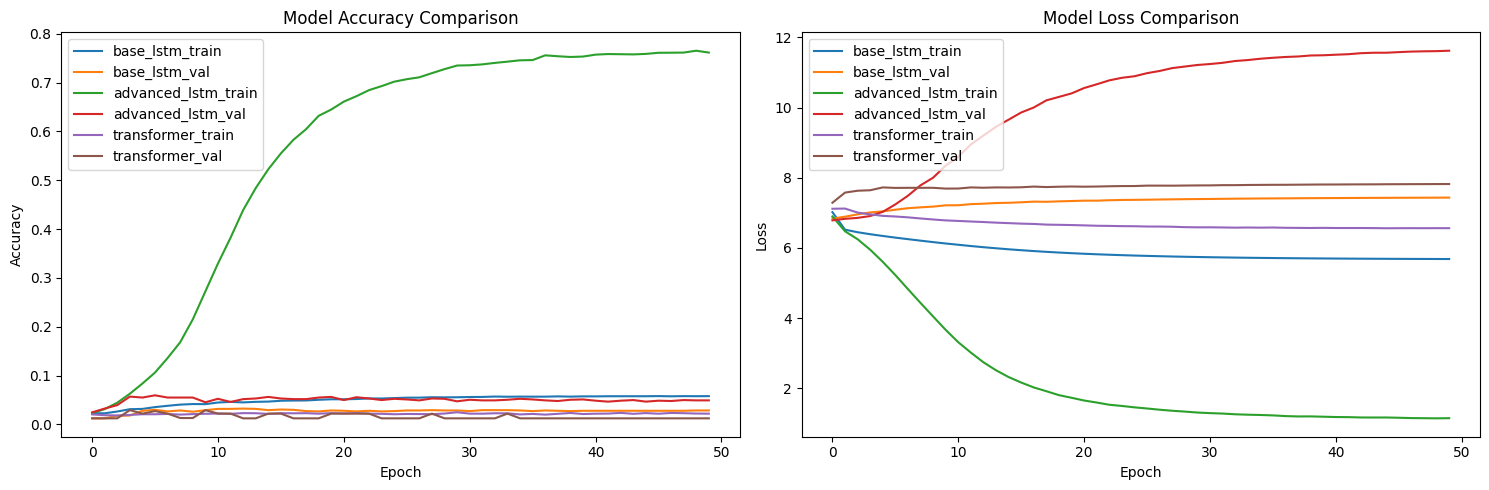

In [28]:
# === Bloque 4: Arquitecturas de Modelo Mejoradas ===
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

class ModelArchitectures:
    def __init__(self, total_words, max_sequence_len):
        self.total_words = total_words
        self.max_sequence_len = max_sequence_len
        self.models = {}
        self.histories = {}

    def build_base_lstm(self):
        """Modelo LSTM original para comparación"""
        model = Sequential([
            Embedding(self.total_words, 100, input_length=self.max_sequence_len-1),
            LSTM(150),
            Dense(self.total_words, activation='softmax')
        ])
        return model

    def build_advanced_lstm(self):
        """LSTM mejorado con attention y regularización"""
        inputs = Input(shape=(self.max_sequence_len-1,))
        x = Embedding(self.total_words, 256)(inputs)
        x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(128))(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.total_words, activation='softmax')(x)
        return Model(inputs, outputs)

    def build_transformer(self):
        """Arquitectura basada en Transformer"""
        def transformer_block(x, units, num_heads):
            attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
            x = Add()([x, attention])
            x = LayerNormalization()(x)
            ffn = Dense(units*2, activation='relu')(x)
            ffn = Dense(units)(ffn)
            x = Add()([x, ffn])
            return LayerNormalization()(x)

        inputs = Input(shape=(self.max_sequence_len-1,))
        x = Embedding(self.total_words, 256)(inputs)
        x = transformer_block(x, 256, 8)
        x = transformer_block(x, 256, 8)
        x = GlobalAveragePooling1D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.total_words, activation='softmax')(x)
        return Model(inputs, outputs)

    def compile_and_train(self, model_name, X_train, y_train, epochs=50):
        """Entrenamiento con configuración mejorada"""
        # Learning rate schedule
        initial_learning_rate = 0.001
        def lr_schedule(epoch):
            return initial_learning_rate * math.exp(-0.1 * epoch)

        # Callbacks
        callbacks = [
            LearningRateScheduler(lr_schedule),
            ModelCheckpoint(
                f'best_{model_name}.keras',
                save_best_only=True,
                monitor='val_loss'
            )
        ]

        # Compilar modelo
        if model_name not in self.models:
            if model_name == 'base_lstm':
                self.models[model_name] = self.build_base_lstm()
            elif model_name == 'advanced_lstm':
                self.models[model_name] = self.build_advanced_lstm()
            elif model_name == 'transformer':
                self.models[model_name] = self.build_transformer()

        self.models[model_name].compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=initial_learning_rate),
            metrics=['accuracy']
        )

        # Entrenamiento
        history = self.models[model_name].fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=128,
            validation_split=0.1,
            callbacks=callbacks,
            verbose=1
        )
        
        self.histories[model_name] = history
        return history

    def compare_models(self):
        """Visualización comparativa de modelos"""
        plt.figure(figsize=(15, 5))
        
        # Gráfico de accuracy
        plt.subplot(1, 2, 1)
        for model_name, history in self.histories.items():
            plt.plot(history.history['accuracy'], label=f'{model_name}_train')
            plt.plot(history.history['val_accuracy'], label=f'{model_name}_val')
        plt.title('Model Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Gráfico de loss
        plt.subplot(1, 2, 2)
        for model_name, history in self.histories.items():
            plt.plot(history.history['loss'], label=f'{model_name}_train')
            plt.plot(history.history['val_loss'], label=f'{model_name}_val')
        plt.title('Model Loss Comparison')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Inicializar y entrenar los modelos
model_architectures = ModelArchitectures(total_words, max_sequence_len)

# Entrenar cada modelo
print("=== Entrenando Modelo Base LSTM ===")
model_architectures.compile_and_train('base_lstm', predictors, labels)

print("\n=== Entrenando Modelo LSTM Avanzado ===")
model_architectures.compile_and_train('advanced_lstm', predictors, labels)

print("\n=== Entrenando Modelo Transformer ===")
model_architectures.compile_and_train('transformer', predictors, labels)

# Comparar resultados
print("\n=== Comparación de Modelos ===")
model_architectures.compare_models()

In [29]:
# === Bloque 5: Estrategias de Generación de Texto Mejoradas ===
class TextGenerator:
    def __init__(self, tokenizer, max_sequence_len):
        self.tokenizer = tokenizer
        self.max_sequence_len = max_sequence_len
        self.reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

    def generate_basic(self, seed_text, model, next_words=20):
        """Método básico de generación (greedy)"""
        output_text = seed_text
        
        for _ in range(next_words):
            # Tokenizar y padear la secuencia
            token_list = self.tokenizer.texts_to_sequences([output_text])[0]
            token_list = pad_sequences([token_list], maxlen=self.max_sequence_len-1, padding='pre')
            
            # Predecir
            predicted = model.predict(token_list, verbose=0)
            predicted_id = np.argmax(predicted, axis=-1)[0]
            
            # Convertir ID a palabra
            output_word = self.reverse_word_map.get(predicted_id, '')
            output_text += ' ' + output_word
            
        return output_text

    def generate_with_temperature(self, seed_text, model, next_words=20, temperature=0.7):
        """Generación con temperature sampling"""
        output_text = seed_text
        
        for _ in range(next_words):
            token_list = self.tokenizer.texts_to_sequences([output_text])[0]
            token_list = pad_sequences([token_list], maxlen=self.max_sequence_len-1, padding='pre')
            
            predictions = model.predict(token_list, verbose=0)[0]
            predictions = np.log(predictions) / temperature
            exp_predictions = np.exp(predictions)
            predictions = exp_predictions / np.sum(exp_predictions)
            
            predicted_id = np.random.choice(len(predictions), p=predictions)
            output_word = self.reverse_word_map.get(predicted_id, '')
            output_text += ' ' + output_word
            
        return output_text

    def generate_with_beam_search(self, seed_text, model, next_words=20, beam_width=3):
        """Generación con beam search"""
        candidates = [(seed_text, 0.0)]
        
        for _ in range(next_words):
            all_candidates = []
            for text, score in candidates:
                token_list = self.tokenizer.texts_to_sequences([text])[0]
                token_list = pad_sequences([token_list], maxlen=self.max_sequence_len-1, padding='pre')
                predictions = model.predict(token_list, verbose=0)[0]
                
                # Obtener top k predicciones
                top_k = np.argsort(predictions)[-beam_width:]
                
                for token_id in top_k:
                    word = self.reverse_word_map.get(token_id, '')
                    candidate = text + ' ' + word
                    candidate_score = score + np.log(predictions[token_id])
                    all_candidates.append((candidate, candidate_score))
            
            # Seleccionar los mejores beam_width candidatos
            candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        
        return candidates[0][0]  # Retornar la mejor secuencia

# Inicializar el generador
generator = TextGenerator(tokenizer, max_sequence_len)

# Probar diferentes métodos de generación
seed_texts = [
    "shall i compare thee to",
    "my love is like a",
    "when in disgrace with fortune"
]

print("=== Comparación de Métodos de Generación ===\n")

for seed_text in seed_texts:
    print(f"\nSeed text: '{seed_text}'\n")
    
    # Generación básica
    basic_text = generator.generate_basic(seed_text, model_architectures.models['advanced_lstm'])
    print("Método Básico:")
    print(basic_text)
    
    # Generación con temperature sampling (más creativa)
    temp_text = generator.generate_with_temperature(seed_text, model_architectures.models['advanced_lstm'], temperature=1.2)
    print("\nTemperature Sampling (T=1.2):")
    print(temp_text)
    
    # Generación con beam search (más coherente)
    beam_text = generator.generate_with_beam_search(seed_text, model_architectures.models['advanced_lstm'])
    print("\nBeam Search:")
    print(beam_text)
    print("\n" + "="*50)

# Crear DataFrame comparativo
results_df = pd.DataFrame({
    'Método': ['Básico', 'Temperature', 'Beam Search'],
    'Ventajas': [
        'Simple y rápido',
        'Más creativo y variado',
        'Más coherente y estructurado'
    ],
    'Desventajas': [
        'Puede ser repetitivo',
        'Puede generar texto menos coherente',
        'Puede ser computacionalmente costoso'
    ]
})

print("\n=== Resumen de Métodos de Generación ===")
print(results_df)

=== Comparación de Métodos de Generación ===


Seed text: 'shall i compare thee to'

Método Básico:
shall i compare thee to a summer's day die see you see well near near near shown to say it shown well shows it full

Temperature Sampling (T=1.2):
shall i compare thee to that the best thing speak my one bed had swear away with wrong assured foul a gainer too bright wit

Beam Search:
shall i compare thee to a summer's day die see you see well near near near shown to die bold bold none none none none


Seed text: 'my love is like a'

Método Básico:
my love is like a old spirit that level my level in me now truth do i grow to last so near well near well

Temperature Sampling (T=1.2):
my love is like a music jewel shame brings hits aside hell of mine as the strength of youth doth view truth might abuse it

Beam Search:
my love is like a old spirit that level my level in me new in thy part can be done brought to guard thy 'will


Seed text: 'when in disgrace with fortune'

Método Básico:
whe


=== Evaluando Modelo: base_lstm ===

Evaluando seed text: 'shall i compare thee to'

BASIC:
Generado: shall i compare thee to the world of thee of thee of thee be follow'd wiry love of thee of thee of thee to thee
Métricas: {'bleu_1': '0.2000', 'bleu_2': '0.1826', 'rouge1_f1': '0.2857', 'rouge2_f1': '0.2000', 'rougeL_f1': '0.2857', 'meteor': '0.3194'}

TEMPERATURE:
Generado: shall i compare thee to a folly hand in is days told to fearing pyramids stretched own love doth becomes doth thoughts to state wretch
Métricas: {'bleu_1': '0.2400', 'bleu_2': '0.2236', 'rouge1_f1': '0.3902', 'rouge2_f1': '0.2564', 'rougeL_f1': '0.3902', 'meteor': '0.4390'}

BEAM_SEARCH:
Generado: shall i compare thee to my love of thee of thee of thee of thee to thee to thee of thee to thee to thee
Métricas: {'bleu_1': '0.2000', 'bleu_2': '0.1826', 'rouge1_f1': '0.2927', 'rouge2_f1': '0.2051', 'rougeL_f1': '0.2927', 'meteor': '0.3194'}

Evaluando seed text: 'my love is like a'

BASIC:
Generado: my love is like a 

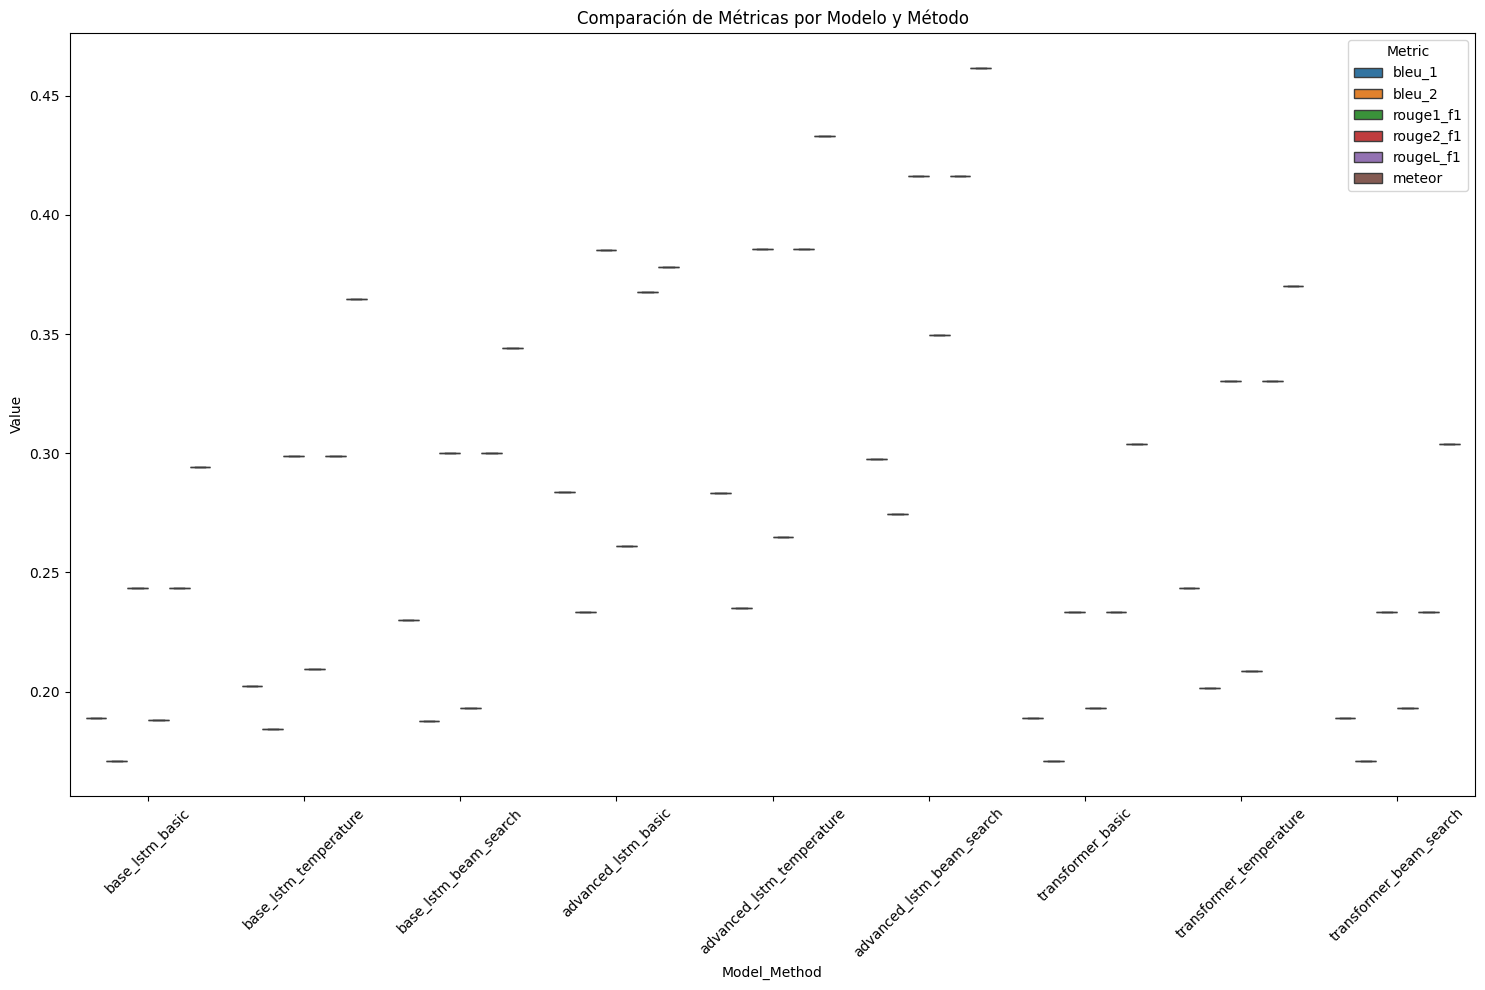


=== Resumen Final de Resultados ===
Metric                     bleu_1  bleu_2  meteor  rouge1_f1  rouge2_f1  \
Model_Method                                                              
advanced_lstm_basic        0.2839  0.2335  0.3782     0.3853     0.2610   
advanced_lstm_beam_search  0.2978  0.2747  0.4619     0.4164     0.3495   
advanced_lstm_temperature  0.2833  0.2349  0.4332     0.3859     0.2651   
base_lstm_basic            0.1889  0.1709  0.2944     0.2436     0.1881   
base_lstm_beam_search      0.2300  0.1877  0.3444     0.3001     0.1931   
base_lstm_temperature      0.2022  0.1845  0.3647     0.2989     0.2097   
transformer_basic          0.1889  0.1709  0.3039     0.2334     0.1931   
transformer_beam_search    0.1889  0.1709  0.3039     0.2334     0.1931   
transformer_temperature    0.2433  0.2014  0.3702     0.3302     0.2088   

Metric                     rougeL_f1  
Model_Method                          
advanced_lstm_basic           0.3678  
advanced_lstm_beam_s

In [30]:
# === Bloque 6: Sistema de Evaluación Completo ===
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import numpy as np
from collections import defaultdict

class TextEvaluator:
    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.smoothing = SmoothingFunction().method1
        self.metrics = defaultdict(dict)
        
    def calculate_perplexity(self, model, X_test, y_test):
        """Calcula la perplejidad del modelo"""
        loss = model.evaluate(X_test, y_test, verbose=0)[0]
        return np.exp(loss)
    
    def calculate_metrics(self, reference, generated):
        """Calcula todas las métricas para un texto generado"""
        ref_tokens = reference.split()
        gen_tokens = generated.split()
        
        # BLEU Score
        bleu_1 = sentence_bleu([ref_tokens], gen_tokens, weights=(1, 0, 0, 0), smoothing_function=self.smoothing)
        bleu_2 = sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=self.smoothing)
        
        # ROUGE Scores
        rouge_scores = self.scorer.score(reference, generated)
        
        # METEOR Score (si está disponible)
        try:
            meteor = meteor_score([ref_tokens], gen_tokens)
        except:
            meteor = None
            
        return {
            'bleu_1': bleu_1,
            'bleu_2': bleu_2,
            'rouge1_f1': rouge_scores['rouge1'].fmeasure,
            'rouge2_f1': rouge_scores['rouge2'].fmeasure,
            'rougeL_f1': rouge_scores['rougeL'].fmeasure,
            'meteor': meteor
        }
    
    def evaluate_model(self, model_name, model, generator, test_cases):
        """Evalúa un modelo con diferentes métodos de generación"""
        methods = ['basic', 'temperature', 'beam_search']
        
        for seed_text, reference in test_cases:
            print(f"\nEvaluando seed text: '{seed_text}'")
            
            for method in methods:
                if method == 'basic':
                    generated = generator.generate_basic(seed_text, model)
                elif method == 'temperature':
                    generated = generator.generate_with_temperature(seed_text, model)
                else:
                    generated = generator.generate_with_beam_search(seed_text, model)
                
                metrics = self.calculate_metrics(reference, generated)
                self.metrics[f"{model_name}_{method}"][seed_text] = {
                    'generated': generated,
                    'metrics': metrics
                }
                
                print(f"\n{method.upper()}:")
                print(f"Generado: {generated}")
                print("Métricas:", {k: f"{v:.4f}" for k, v in metrics.items() if v is not None})

    def generate_report(self):
        """Genera un reporte comparativo completo"""
        report = defaultdict(list)
        
        for model_method in self.metrics:
            avg_metrics = defaultdict(float)
            count = 0
            
            for seed_text in self.metrics[model_method]:
                metrics = self.metrics[model_method][seed_text]['metrics']
                for metric, value in metrics.items():
                    if value is not None:
                        avg_metrics[metric] += value
                count += 1
            
            # Calcular promedios
            for metric in avg_metrics:
                avg_metrics[metric] /= count
                report['Model_Method'].append(model_method)
                report['Metric'].append(metric)
                report['Value'].append(avg_metrics[metric])
        
        return pd.DataFrame(report)

# Crear casos de prueba
test_cases = [
    ("shall i compare thee to", "shall i compare thee to a summer's day thou art more lovely and more temperate"),
    ("my love is like a", "my love is like a red red rose that's newly sprung in june"),
    ("when in disgrace with", "when in disgrace with fortune and men's eyes i all alone beweep my outcast state")
]

# Inicializar evaluador
evaluator = TextEvaluator()

# Evaluar cada modelo
for model_name in model_architectures.models:
    print(f"\n=== Evaluando Modelo: {model_name} ===")
    evaluator.evaluate_model(
        model_name,
        model_architectures.models[model_name],
        generator,
        test_cases
    )

# Generar y mostrar reporte final
report_df = evaluator.generate_report()

# Visualización de resultados
plt.figure(figsize=(15, 10))
sns.boxplot(data=report_df, x='Model_Method', y='Value', hue='Metric')
plt.xticks(rotation=45)
plt.title('Comparación de Métricas por Modelo y Método')
plt.tight_layout()
plt.show()

# Crear tabla de resumen
summary_pivot = report_df.pivot_table(
    index='Model_Method',
    columns='Metric',
    values='Value',
    aggfunc='mean'
)

print("\n=== Resumen Final de Resultados ===")
print(summary_pivot.round(4))

# Guardar resultados
summary_pivot.to_csv('model_comparison_results.csv')
print("\nResultados guardados en 'model_comparison_results.csv'")